<a href="https://colab.research.google.com/github/Balloni/study_kaggle_house_price_prediction./blob/main/study_kaggle_house_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import dask.dataframe as dd
import plotly.express as px
from dask.diagnostics import ProgressBar
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_scor

# **Part 1: Data Preparation and Exploration (Python, SQL)**








---



In [ ]:
!kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset


Dataset URL: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset
License(s): other
usa-real-estate-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:

zip_file_path = "/content/usa-real-estate-dataset.zip"

try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")  # Extract to /content/

  # Find the CSV file within the extracted directory (adjust if necessary)
  import os
  for filename in os.listdir("/content/"):
      if filename.endswith(".csv"):
          csv_file_path = os.path.join("/content/", filename)
          break
  else:
      print("No CSV file found in the extracted directory.")
      csv_file_path = None

  if csv_file_path:
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(csv_file_path)
    display(df.head(10)) #Display first few rows
    # Now you can work with the DataFrame 'df'
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file '{zip_file_path}' was not found.")
except zipfile.BadZipFile:
    print(f"Error: '{zip_file_path}' is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN
5,103378.0,for_sale,179000.0,4.0,3.0,0.46,1850806.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN
6,1205.0,for_sale,50000.0,3.0,1.0,0.20,1298094.0,Ciales,Puerto Rico,639.0,2040.0,NaN
7,50739.0,for_sale,71600.0,3.0,2.0,0.08,1048466.0,Ponce,Puerto Rico,731.0,1050.0,NaN
8,81909.0,for_sale,100000.0,2.0,1.0,0.09,734904.0,Ponce,Puerto Rico,730.0,1092.0,NaN
9,65672.0,for_sale,300000.0,5.0,3.0,7.46,1946226.0,Las Marias,Puerto Rico,670.0,5403.0,NaN


Dataset loaded successfully!


In [ ]:
df = pd.DataFrame(df)

# Verificar valores faltantes
print(df.isnull().sum())

brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64


In [ ]:
# 1. Handle missing data
# Remove rows with missing 'price', 'state', or 'house_size', and create a clean copy
df_clean = df.dropna(subset=['price', 'state', 'house_size']).copy()

# **Part 2: Data Analysis and Visualization (Python)**

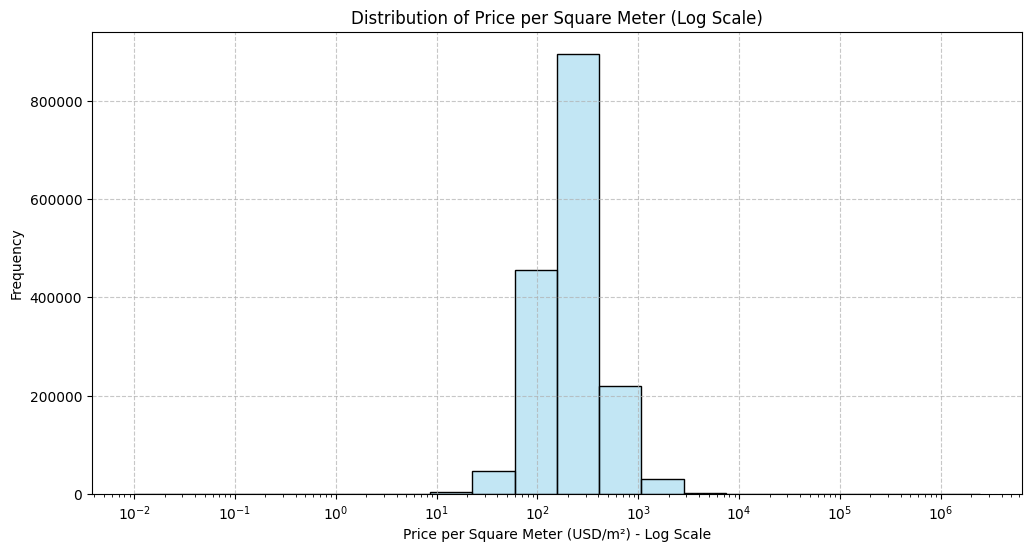

In [ ]:


# 2. Calculate price per square meter and round to 2 decimal places
df_clean['price_per_sqm'] = (df_clean['price'] / df_clean['house_size']).round(2)

# 3. Distribution of price per square meter (with logarithmic scale)
plt.figure(figsize=(12, 6))
sns.histplot(df_clean['price_per_sqm'], kde=True, color='skyblue', bins=20, log_scale=True)  # Use log scale
plt.title('Distribution of Price per Square Meter (Log Scale)')
plt.xlabel('Price per Square Meter (USD/m²) - Log Scale')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<ipython-input-28-b906c50d6853>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




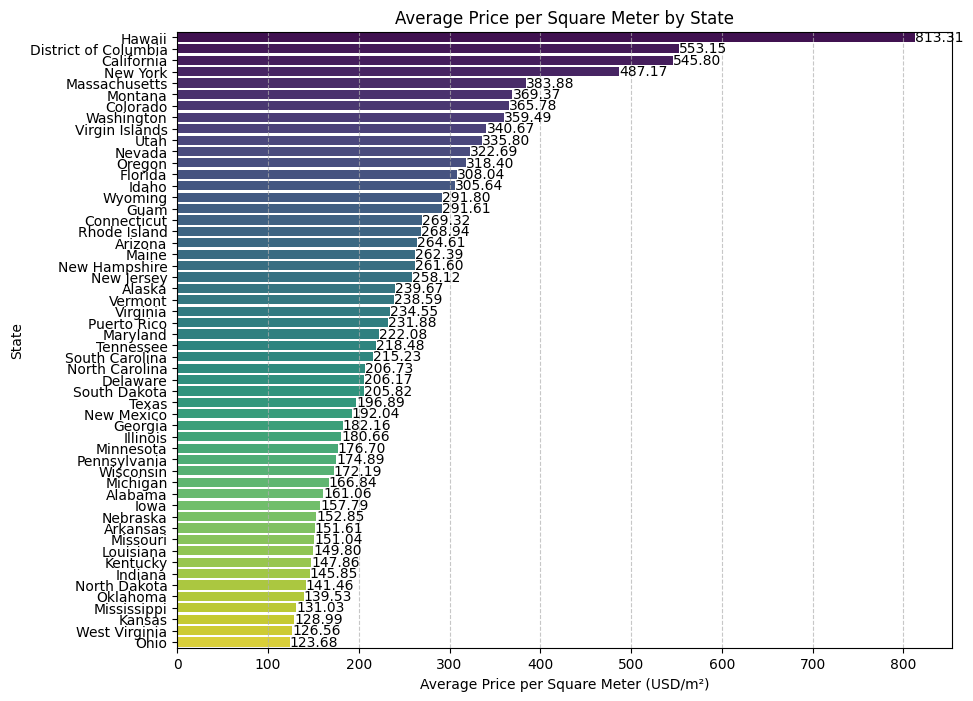

In [ ]:


# 4. Average price per square meter by state (rounded to 2 decimal places)
plt.figure(figsize=(10, 8))
state_avg_sqm = df_clean.groupby('state')['price_per_sqm'].mean().round(2).sort_values(ascending=False)

# Create the horizontal bar plot
bar_plot = sns.barplot(x=state_avg_sqm.values, y=state_avg_sqm.index, palette='viridis', orient='h')

# Add the value of price per square meter on each bar
for i, value in enumerate(state_avg_sqm.values):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', fontsize=10, color='black')

# Add titles and labels
plt.title('Average Price per Square Meter by State')
plt.xlabel('Average Price per Square Meter (USD/m²)')
plt.ylabel('State')
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Grid on x-axis
plt.show()

# **Part 3: Basic Price Prediction Model (Python, Machine Learning)**





In [ ]:


# 1. Prepare the Data
# Check the column names in your DataFrame
print(df_clean.columns)

# Update the feature list based on the actual column names
features = ['state', 'house_size', 'bed', 'bath']  # Updated feature names
target = 'price'  # Target variable

# Handle missing values (if any)
df_clean = df_clean.dropna(subset=features + [target])

# Encode categorical variables (e.g., 'state') using one-hot encoding
categorical_features = ['state']  # List of categorical columns
numerical_features = ['house_size', 'bed', 'bath']  # List of numerical columns

# Create a ColumnTransformer to apply one-hot encoding to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)  # One-hot encode categorical features
    ],
    remainder='passthrough'  # Keep numerical features as they are
)

# Apply the preprocessing
X = df_clean[features]
y = df_clean[target]
X_processed = preprocessor.fit_transform(X)

# 2. Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 3. Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Evaluate the Model
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# 5.  Make Predictions on New Data
# Example: Predict the price of a new property
new_property = pd.DataFrame({
    'state': ['Puerto Rico'],  # Example: Puerto Rico
    'house_size': [150],  # Size in m²
    'bed': [3],  # Number of bedrooms
    'bath': [2]  # Number of bathrooms
})

# Preprocess the new data
new_property_processed = preprocessor.transform(new_property)

# Predict the price
predicted_price = model.predict(new_property_processed)
print(f"Predicted Price for the New Property: ${predicted_price[0]:.2f}")

Index(['brokered_by', 'status', 'price', 'bed', 'bath', 'acre_lot', 'street',
       'city', 'state', 'zip_code', 'house_size', 'prev_sold_date',
       'price_per_sqm'],
      dtype='object')
Mean Squared Error (MSE): 1956839230517.14
R-squared (R²): 0.12
Predicted Price for the New Property: $309519.11


# **Part 4:Bonus comparação modelos**


In [ ]:
# 1. Prepare the Data
# Select relevant features
features = ['state', 'house_size', 'bed', 'bath']  # Example of features
target = 'price'  # Target variable

# Handle missing values (if any)
df_clean = df_clean.dropna(subset=features + [target])

# Encode categorical variables (e.g., 'state') using one-hot encoding
categorical_features = ['state']  # List of categorical columns
numerical_features = ['house_size', 'bed', 'bath']  # List of numerical columns

# Create a ColumnTransformer to apply one-hot encoding to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode for categorical features
    ],
    remainder='passthrough'  # Keep numerical features as they are
)

# Apply preprocessing
X = df_clean[features]
y = df_clean[target]
X_processed = preprocessor.fit_transform(X)

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 3. Train and Evaluate Models
# Function to train and evaluate a model
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2

# Initialize models
linear_reg = LinearRegression()
random_forest = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)  # Optimized settings

# Train and evaluate each model
linear_reg_mse, linear_reg_r2 = train_and_evaluate(linear_reg, X_train, X_test, y_train, y_test)
random_forest_mse, random_forest_r2 = train_and_evaluate(random_forest, X_train, X_test, y_train, y_test)

# 4. Compare Results
results = {
    'Model': ['Linear Regression', 'Random Forest'],
    'MSE': [linear_reg_mse, random_forest_mse],
    'R²': [linear_reg_r2, random_forest_r2]
}

results_df = pd.DataFrame(results)
print(results_df)

               Model           MSE        R²
0  Linear Regression  1.956839e+12  0.120143
1      Random Forest  1.679923e+12  0.244653
